In [1]:
__author__ = 'Leah Fulmer, NOAO Data Lab Team'
__version__ = '20190103' # yyyymmdd
__datasets__ = ['decaps_dr1']
__keywords__ = ['Milky Way','stars','plot:color-color','plot:cmd']

# Galactic Structure from the DECam Plane Survey (DECaPS)
by Leah Fulmer, Stéphanie Juneau, Knut Olsen and the NOAO Data Lab Team

### Table of Contents
* [Disclaimer & Attribution](#attribution)
* [Goals & Summary](#introduction)
* [Imports & Setup](#import)
* [DECaPS Object Catalog Exploration](#explore)
* [DECaPS Object Catalog Query: Field Stars](#field)
    * [Visualize Objects to Query](#field1)
    * [Construct a SQL Query](#field2)
    * [Submit the SQL Query](#field3)
    * [Define Data Selection Threshold for Analysis](#field4)
    * [Plot Results](#field5)
    * [Examine Objects in the Legacy Survey Sky Viewer](#field6)
* [DECaPS Object Catalog Query: Dusty Region](#dusty)
    * [Visualize Objects to Query](#dusty1)
    * [Construct and Submit a SQL Query](#dusty2)
    * [Define Data Selection Threshold for Analysis](#dusty3)
    * [Plot Results](#dusty4)
    * [Examine Objects in the Legacy Survey Sky Viewer](#dusty5)
* [DECaPS Object Catalog Query: Open Cluster 2447](#2447)
    * [Visualize Objects to Query](#24471)
    * [Construct and Submit a SQL Query](#24472)
    * [Define Data Selection Threshold for Analysis](#24473)
    * [Plot Results](#24474)
    * [Examine Objects in the Legacy Survey Sky Viewer](#24475)
* [Resources & References](#resources)

<a class="anchor" id="attribution"></a>
# Disclaimer & Attribution

#### If you use this notebook for your published science, please acknowledge the following:

* Data Lab Concept Paper: [Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014](http://dx.doi.org/10.1117/12.2057445)

* [Data Lab Disclaimer](http://datalab.noao.edu/disclaimers.php)

<a class="anchor" id="introduction"></a>
# Goals
* Explore the DECaPS DR1 catalog and survey
* Construct a simple SQL query relevant to DECaPS DR1
* Make color-color and color-magnitude diagrams of selected regions
* Examine regions of interest through links to the legacysurvey.oprg Sky Viewer

# Summary

We demonstrate NOAO Data Lab science cases using the Dark Energy Camera Plane Survey (DECaPS) database. Specifically, we investigate Galactic structure by visualizing color-color and color-magnitude diagrams for stellar populations within the Galactic bulge, star clusters, and field.


#### DECaPS Information:
DECaPS (Schlafly et al. 2017) is a Dark Energy Camera (DECam) optical and near-infrared survey of the southern Galactic plane covering five wavelength bands (g, r, i, z, Y). The survey solves for the positions and fluxes of all sources simultaneously, delivering these values for ~2 billion stars with up to 5mmag repeatability. Most DECaPS objects are highly reddened and deep in the Galactic disk, thus probing the structure and properties of the Milky Way and its ISM. 

DECaPS was designed to reach past the main-sequence turn-off at the Galactic center distance through 1.5 mag E(B-V) reddening. The typical single-exposure depth in the grizY bands are 23.7, 22.8, 22.2, 21.8, and 21.0 mag respectively, with 1'' seeing. The survey footprint covers a total of ~1000 square deg, within the limits | $b$ | < 4°, 5° > $l$ > −120° (the low-latitude Galactic plane south of $δ$ < −30°).

<a class="anchor" id="import"></a>
# Imports & Setup

In [13]:
## Data Lab imports
from dl import queryClient as qc

## External imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML

<a class="anchor" id="explore"></a>
# DECaPS Object Catalog Exploration

For this Notebook, we will use the **decaps_dr1** database, which includes several tables. The names and descriptions for each table, column can be found with the [Data Lab Query Interface](http://datalab.noao.edu/query.php) or using the Table Access Protocol (TAP) service through TOPCAT. Below we examine the available tables in **decaps_dr1** using qc.schema(), a queryClient method that provides catalog metadata.

In [14]:
## Examine the available tables within decaps_dr1
print(qc.schema('decaps_dr1',format='json'))


Schema: decaps_dr1

      Table Name   Description
      ----------   -----------
            ccds   Brick CCD table
           depth   Brick depth table
            imdb   Image table contains the headers from all images composing
                   the DECaPS survey.
          object   Band-merged catalogs for all objects
             zps   Zero points and flat fields from the photometric calibrati
                   n, as well as some quality assurance information.



For this Notebook, we will use the table **decaps_dr1.object**. Below we examine the available columns in **decaps_dr1.object**, again using qc.schema().

In [15]:
## Examine the available columns within decaps_dr1.object
print(qc.schema('decaps_dr1.object',format='json'))


Schema: decaps_dr1
 Table: object

     Column Name   Description
     -----------   -----------
             _id   
          obj_id   Unique DECaPS object ID
              ra   Right ascension (degrees)
             dec   Declination (degrees)
      epochrange   MJD difference between first and last detection
       epochmean   Mean MJD
            elon   Ecliptic Longitude
            elat   Ecliptic Latitude
            glon   Galactic Longitude
            glat   Galactic Latitude
           ra_ok   Right ascension, good detections only (degrees)
          dec_ok   Declination, good detections only (degrees)
   epochrange_ok   MJD difference between first and last good detection
    epochmean_ok   Mean good MJD
            htm9   HTM index (order 9 => ~10 arcmin size)
         ring256   HEALPIX index (Nsides 256, Ring scheme => ~14 arcmin size)
        nest4096   HEALPIX index (Nsides 4096, Nest scheme => ~52 arcsec size
       random_id   Random ID in the range 0.0 => 100.0
    

<a class="anchor" id="field"></a>
# DECaPS Object Catalog Query: Field Stars

<a class="anchor" id="field1"></a>
## Visualize Objects to Query

For the first query, we select a region removed from the plane in order to examine Galactic field stars. The location is in the neighborhood of RA = 187 Dec = -68.5 (l = 300 b = -6), indicated by the red star in the figure below. To view this region in the Legacy Survey Sky Viewer, click the link in the image caption.

<figure>
<center>
<img src="Field Region.png", width=950>
<figcaption>DECaPS Galactic Plane as shown in the Legacy Survey Sky Viewer. Red star indicates the queried region. <a href="http://legacysurvey.org/viewer?ra=187.2558&dec=-68.5091&zoom=9&layer=decaps&ngc">Link to Sky Viewer Location.</a> </figcaption>
</center>
</figure>

<a class="anchor" id="field2"></a>
## Construct a SQL Query

The following query performs a box search with size of ~1 degree, retrieving the columns for object id, celestial coordinates, and photometric measurements. The value "fracflux" in each band indicates the fraction of flux at the location of a source contributed by the source itself. Fracflux offers a measure of the blendedness or crowding of a particular source. We construct the query to ignore objects with invalid photometry in g, r, and i.

In [16]:
## Write SQL query statement as a string.

## If you give the system an impossible query, it will return the following:
## "Error: The query is not suitable for a synchronous operation" 
query1 = """
        SELECT obj_id, ra, dec, mean_mag_g_r, mean_mag_r_i,
        mean_mag_g, mean_mag_r, mean_mag_i, fracflux_g, fracflux_r, fracflux_i
        FROM decaps_dr1.object
        WHERE (ra<187.5 AND ra>187.0 AND dec<-68.3 AND dec>-68.7 
        AND NOT mean_mag_g_r='Nan' AND NOT mean_mag_g_r='Infinity' AND NOT mean_mag_g_r='-Infinity' 
        AND NOT mean_mag_r_i='Nan' AND NOT mean_mag_r_i='Infinity' AND NOT mean_mag_r_i='-Infinity')
        LIMIT 100000"""

<a class="anchor" id="field3"></a>
## Submit the SQL Query

Submit the query and return the output as a Pandas dataframe using qc.query(). Examine the first few lines of the output to check that all values make sense.

In [17]:
%%time
# Submit the SQL query
df1 = qc.query(sql=query1,fmt='pandas')

# Examine query output
print("\n", df1[:4], "\n")


 Empty DataFrame
Columns: [obj_id, ra, dec, mean_mag_g_r, mean_mag_r_i, mean_mag_g, mean_mag_r, mean_mag_i, fracflux_g, fracflux_r, fracflux_i]
Index: [] 

CPU times: user 35 ms, sys: 2 ms, total: 37 ms
Wall time: 96.7 ms


<a class="anchor" id="field4"></a>
## Define Data Selection Threshold for Analysis

In order to select only stars that are not subject to significant blending, we define a data selection threshold based on the column "fracflux" in each band. We choose the threshold 0.9 to ensure that each selected source contributes 90% of the total flux within its PSF. We also check the number of sources in our sample before and after applying the selection threshold.

In [64]:
# Print number of objects in initial query.
def print_initial(df_in):
    print("This query initially contained %s objects." % len(df_in))

print_initial(df1)

# Define variables while applying a data selection threshold
def variables_after_threshold(df_in, threshold):
    
    # Create a threshold for fracflux_* variables. This helps to avoid background / field stars.
    keep = (df_in['fracflux_g'] > threshold)&(df_in['fracflux_r'] > threshold)&(df_in['fracflux_i'] > threshold)
    
    # Define coordinates, magnitude, and colors with the applied data threshold.
    ra = df_in['ra'][keep]
    dec = df_in['dec'][keep]
    g = df_in['mean_mag_g'][keep]
    g_r = df_in['mean_mag_g_r'][keep]
    r_i = df_in['mean_mag_r_i'][keep]
    
    return ra, dec, g, g_r, r_i

ra, dec, g, g_r, r_i = variables_after_threshold(df1, 0.9)

def print_final(var_in):
    print("After refined data selection, this query now contains %s objects." % len(var_in))
    
print_final(ra)

This query initially contained 32689 objects.
After refined data selection, this query now contains 18747 objects.


<a class="anchor" id="field5"></a>
## Plot Results

We plot color-color (g-r, r-i) and color-magnitude (g-r, g) diagrams for our selected objects.  As our selection intentionally includes field stars, the color-color diagram shows a narrow stellar locus, while the CMD contains the signature of the thin Galactic disk.

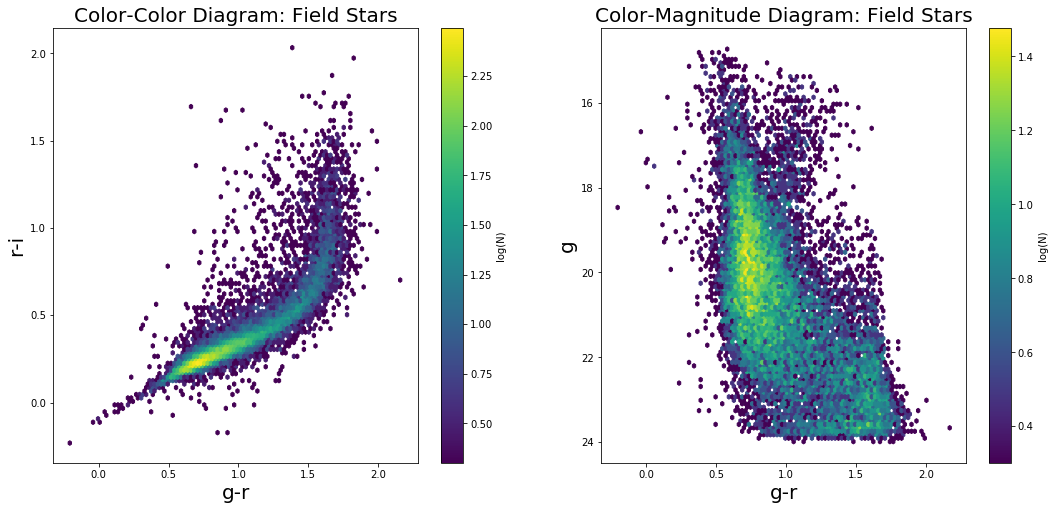

In [65]:
# Plot color-color diagram and color-magnitude diagram

def plot_results(x1, y1, title1, x1_label, y1_label, x2, y2, title2, x2_label, y2_label):
    # Define figure and subplots
    fig = plt.figure(figsize=(18, 8))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    # First subplot
    im1 = ax1.hexbin(x1, y1, bins='log', cmap=plt.cm.viridis, mincnt=1, extent=(min(x1), max(x1), min(y1), max(y1)))
    ax1.set_title(title1,fontsize=20)
    ax1.set_xlabel(x1_label,fontsize=20)
    ax1.set_ylabel(y1_label,fontsize=20)
    cb1 = plt.colorbar(im1,ax=ax1,label='log(N)')
    
    # Second subplot
    im2 = ax2.hexbin(x2, y2, bins='log', cmap=plt.cm.viridis, mincnt=1)
    ax2.set_title(title2,fontsize=20)
    ax2.set_xlabel(x2_label,fontsize=20)
    ax2.set_ylabel(y2_label,fontsize=20)
    ax2.set_ylim([max(y2) + 0.5, min(y2) - 0.5])
    cb2 = plt.colorbar(im2,ax=ax2,label='log(N)')

plot_results(g_r, r_i, 'Color-Color Diagram: Field Stars', 'g-r', 'r-i', 
             g_r, g, 'Color-Magnitude Diagram: Field Stars', 'g-r', 'g')

<a class="anchor" id="field6"></a>
## Examine Objects in the Legacy Survey Sky Viewer

We can selected an even more refinded subsample of our data in order to examine individual objects with the Legacy Survey Sky Viewer. The Sky Viewer offers an interactive map of the entire DECaPS catalog, as well as many other datasets. In order to isolate only a few objects from our data, we define a function that receives a particular selection criteria, identifies the objects that align with that criteria, and  returns a series of Sky Viewer links for those objects. 

User inputs for this function include selection criteria, Sky Viewer zoom level, and output object limit. Function outputs include the constructed Sky Viewer link and the associated photometric measurements for each object.

In [66]:
# Define function that provides links to the Legacy Survey Sky Viewer for a series of objects
def create_sky_viewer_link(selection, zoom, obj_limit):
    ra_select = ra[selection]
    dec_select = dec[selection]
    g_select = g[selection]
    g_r_select = g_r[selection]
    r_i_select = r_i[selection]
    
    if obj_limit <= len(ra_select):
        print("Selected Objects ("+str(obj_limit)+" out of "+str(len(ra_select))+"):")
    else:
        print("Selected Objects ("+str(len(ra_select))+" out of "+str(len(ra_select))+"):")
        
    for i in range(len(ra_select)):
        if i < obj_limit:
            link_string = "http://decaps.legacysurvey.org/viewer/decaps?ra=" \
            +str(ra_select.iloc[i])+"&dec="+str(dec_select.iloc[i])+"&zoom=" \
            +str(zoom)+"&layer=decaps"#, ":", "g_r =",g_r_select.iloc[i]
            display(HTML("<a href="+link_string+" target='_blank'>Link to Legacy Survey Sky Viewer: (" \
                    +str(ra_select.iloc[i])+", "+str(dec_select.iloc[i])+")</a> || g = " \
                    +str(g_select.iloc[i])+", g_r = "+str(g_r_select.iloc[i])+", r_i = " \
                    +str(r_i_select.iloc[i])))
        else:
            pass

# Execute function, providing selection criteria, Sky Viewer zoom level, and output object limit
create_sky_viewer_link((g_r > 1.3) & (g < 16), 14, 4)

Selected Objects (4 out of 5):


<a class="anchor" id="dusty"></a>
# DECaPS Object Catalog Query: Dusty Region

<a class="anchor" id="dusty1"></a>
## Visualize Objects to Query

For our second example, we pick a field a embedded in the plane behind a significant dust lane. The location is in the neighborhood of RA = 135 Dec = -44 (l = 265 b = 1.5), indicated by the red star in the figure below.

<figure>
<center>
<img src="Dusty Region.png", width=950>
<figcaption>DECaPS Galactic Plane as shown in the Legacy Survey Sky Viewer. Red Star indicates the queried region. <a href="http://legacysurvey.org/viewer?ra=135.2032&dec=-44.338&zoom=9&layer=decaps&ngc">Link to Sky Viewer Location.</a></figcaption>
</center>
</figure>

<a class="anchor" id="dusty2"></a>
## Construct and Submit a SQL Query

We apply a box search, selecting the RA and Dec limits that align with the region indicated above.

In [67]:
%%time

## Write SQL query statement as a string.
query2 = """
        SELECT obj_id, ra, dec, mean_mag_g_r, mean_mag_r_i,
        mean_mag_g, mean_mag_r, mean_mag_i, fracflux_g, fracflux_r, fracflux_i
        FROM decaps_dr1.object
        WHERE (ra>134.7 AND ra<135.7 AND dec<-43.7 AND dec>-44.9
        AND NOT mean_mag_g_r='Nan' AND NOT mean_mag_g_r='Infinity' AND NOT mean_mag_g_r='-Infinity' 
        AND NOT mean_mag_r_i='Nan' AND NOT mean_mag_r_i='Infinity' AND NOT mean_mag_r_i='-Infinity')
        LIMIT 100000"""

# Sumbit the SQL query and return the output as a Pandas dataframe.
df2 = qc.query(sql=query2, fmt='pandas')

CPU times: user 58 ms, sys: 9 ms, total: 67 ms
Wall time: 12.4 s


<a class="anchor" id="dusty3"></a>
## Define Variables with Data Selection Threshold

We make a refinded selection of the query results in order to avoid objects subject to significant crowding.

In [68]:
# Print number of objects in initial query.
print_initial(df2)

# Define variables while applying a data selection threshold
ra, dec, g, g_r, r_i = variables_after_threshold(df2, 0.9)

# Print number of objects after quality threshold applied.
print_final(ra)

This query initially contained 10216 objects.
After refined data selection, this query now contains 8970 objects.


<a class="anchor" id="dusty4"></a>
## Plot Results

The color-color and color-magnitude diagrams of this region show clear signs of variable and patchy dust. In the color-color diagram, a number of stars have been shifted from the usual stellar locus by several magnitudes along the reddening vector, which runs diagonally in the diagram.  The CMD reveals these stars toward the red and faint part of the diagram. We see that the normally vertical signature of thin disk turnoff stars have a diagonal tilt, which indicates that stars at larger distance experience more attenuation by dust.  These diagrams could be modelled to recover the three-dimensional dust distribution along the line of sight.

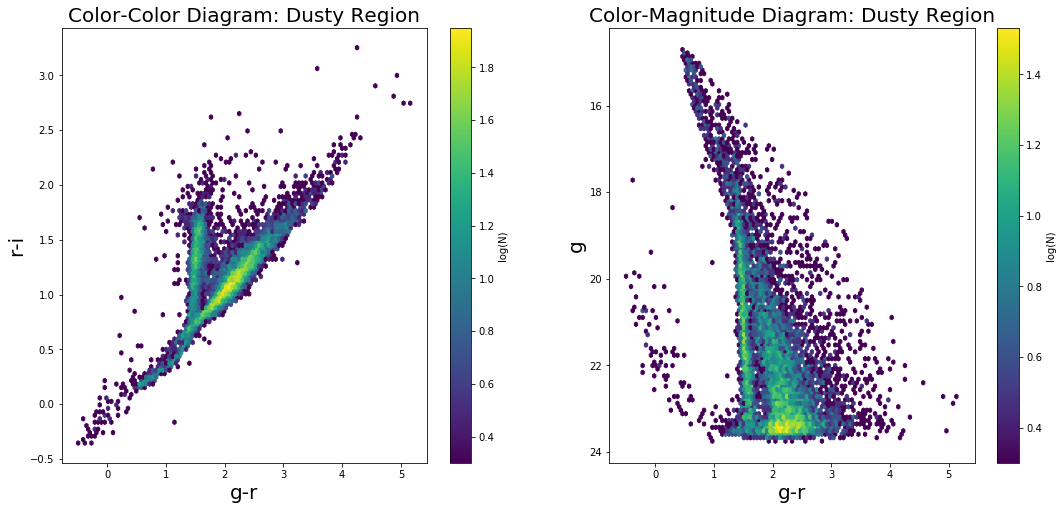

In [69]:
# Plot color-color diagram and color-magnitude diagram
plot_results(g_r, r_i, 'Color-Color Diagram: Dusty Region', 'g-r', 'r-i', 
             g_r, g, 'Color-Magnitude Diagram: Dusty Region', 'g-r', 'g')

<a class="anchor" id="dusty5"></a>
## Examine Objects in the Legacy Survey Sky Viewer

In order to highlight the two stellar populations (those being in front versus behidn the dust), we select stars of roughly the same r-i color and very different g-r colors. By examining these objects in the Sky Viewer, we can visually inspect the presence or absence of dust in the following regions.

In [18]:
# Create links to the Legacy Survey Sky Viewer for a series of objects

print("Redder stars where dust present...")
create_sky_viewer_link((r_i < 1.6006) & (r_i > 1.60) & (g_r > 1.8), 11, 2)

print("Bluer stars where dust absent...")
create_sky_viewer_link((r_i < 1.6006) & (r_i > 1.60) & (g_r < 1.8), 11, 2)
print(" ")

Redder stars where dust present...


NameError: name 'create_sky_viewer_link' is not defined

<a class="anchor" id="2447"></a>
# DECaPS Object Catalog Query: Open Cluster NGC 2447

<a class="anchor" id="24471"></a>
## Visualize Objects to Query
In our last query, we choose a region around the open cluster NGC 2447: RA, Dec = 116.1667, -68.8823  ;  l, b = 280, -20

<figure>
<center>
<img src="Open Cluster.png", width=950>
<figcaption>DECaPS Galactic Plane as shown in the Legacy Survey Sky Viewer. Red star indicates the queried region. <a href="http://legacysurvey.org/viewer?ra=116.1244&dec=-23.8487&zoom=11&layer=decaps&ngc">Link to Sky Viewer Location.</a></figcaption>
</center>
</figure>

<a class="anchor" id="24472"></a>
## Construct and Submit a SQL Query

We apply a box search, selecting the RA and Dec limits that align with the region indicated above.

In [71]:
%%time

## Write SQL query statement as a string.
query3 = """
        SELECT obj_id, ra, dec, 
        mean_mag_g_r, mean_mag_r_i,
        mean_mag_g, mean_mag_r, mean_mag_i,
        fracflux_g, fracflux_r, fracflux_i
        FROM decaps_dr1.object
        WHERE (ra > 115.8 AND ra < 116.5 AND dec < -23.4 AND dec > -24.1 AND mean_mag_g_r > -1
        AND NOT mean_mag_g_r='Nan' AND NOT mean_mag_g_r='Infinity' AND NOT mean_mag_g_r='-Infinity' 
        AND NOT mean_mag_r_i='Nan' AND NOT mean_mag_r_i='Infinity' AND NOT mean_mag_r_i='-Infinity')
        LIMIT 100000"""

# Sumbit the SQL query and return the output as a Pandas dataframe.
df3 = qc.query(sql=query3, fmt='pandas')

CPU times: user 216 ms, sys: 55 ms, total: 271 ms
Wall time: 6.4 s


<a class="anchor" id="24473"></a>
## Define Variables with Data Selection Threshold

We make a refinded selection of the query results in order to avoid objects subject to significant crowding.

In [72]:
# Print number of objects in initial query.
print_initial(df3)

# Define variables while applying a data selection threshold
ra, dec, g, g_r, r_i = variables_after_threshold(df3, 0.9)

# Print number of objects after quality threshold applied.
print_final(ra)

This query initially contained 60156 objects.
After refined data selection, this query now contains 44981 objects.


<a class="anchor" id="24474"></a>
## Plot Results

In the resulting CMD, we see the cluster sequence for NGC 2447.

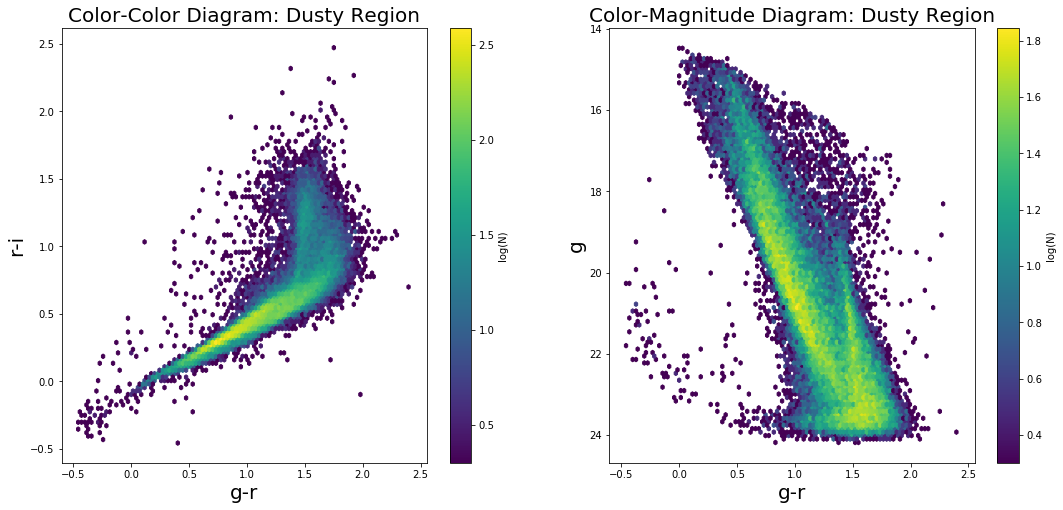

In [73]:
# Plot color-color diagram and color-magnitude diagram
plot_results(g_r, r_i, 'Color-Color Diagram: Dusty Region', 'g-r', 'r-i', 
             g_r, g, 'Color-Magnitude Diagram: Dusty Region', 'g-r', 'g')

<a class="anchor" id="24475"></a>
## Examine Objects in the Legacy Survey Sky Viewer

Below we examine objects within the white dwarf sequence, with color and magnitude selections based on the CMD above.

In [74]:
# Create links to the Legacy Survey Sky Viewer for a series of objects
create_sky_viewer_link((g_r < 0) & (g > 20) & (g < 20.5), 15, 2)

Selected Objects (2 out of 5):


<a class="anchor" id="resources"></a>
## Resources & References

* [DECaPS ADS Link (Schlafly+ 2017)](https://arxiv.org/pdf/1710.01309.pdf) <br>
* [DECaPS Team Website](http://decaps.skymaps.info) <br>
* [Data Lab DECaPS Page](http://datalab.noao.edu/decaps/decaps.php) <br>
* [Legacy Survey Interactive Viewer](http://legacysurvey.org/viewer)